# New Baseline Regression Models with Transformed Data

##### Modeling Step 3

### Notebook Summary:

#### Objective: improve the new baseline model to predict AirBnB listing prices by trying Nonlinear Regression models, or adding 200 features obtained from calculating ratios between existing features and then performing Feature Selection with Recursive Feature Elimination

* Nonlinear attempts consist of first modeling only with interaction features, and then modeling with quadratic terms 
* Features to be used to calculate ratios were selected arbitrarily, focusing on distance features (e.g. distance to ocean, distance to closest city recreation site, etc.) and count features (e.g. count of events within 1 KM vs count of parks within 1 KM) 

#### Conclusions: 
* Nonlinear attempts are highly computationally expensive and perform poorly in terms of model accuracy 
* Adding ratio features provides a small improvement to the baseline model picked in the "new_baseline_model" notebook 
* Performing feature selection with RFECV on the expanded dataset identifies 147 features as the optimal set that minimizes validation RMSE, but the new performance metrics show slightly lower accuracy. Despite that, we prefer to use this smaller set of features as it provides a much simpler model i.e. a model with 100 ca. less features  
* ##### Linear Regression with the expanded but then "selected" dataset is therefore our new best model

#### Next Steps: 
###### In the regularization notebook we use Lasso, Ridge and Elastic Net Regression models in order to further improve our model by simplifying it while also not giving up accuracy results obtained thus far

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [3]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve

In [4]:
import sys
sys.path.append('./../lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions, rank_to_dict
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features, plot_accuracy_instances
from model_visualizations import plot_learning_curve

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
%store -r scores_lin 
%store -r scores_tree 
%store -r scores_sv_reg 
%store -r scores_neigh_reg

In [6]:
%store -r best_model_svr 
%store -r best_model_kneigh 
%store -r best_model_dtree 
%store -r lin_reg

In [7]:
%store -r X_ratios
%store -r X_normed
%store -r X_test
%store -r y_normed
%store -r y_test
%store -r listings

In [8]:
%store -r ranks

Feature Interactions - We do this in two ways - first we check and add the interactions that increase accuracy beyond an arbitrary threshold (0.02); Then, we just add all interactions

In [9]:
increments = detect_interactions(X_normed,y_normed, 0.02)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [10]:
X_normed_wint = add_interactions(X_normed, increments)

In [11]:
increments.shape

(0, 3)

The above did not return any interactions! That means the interactions are probably not going to make large changes to our models above

In [12]:
poly = PolynomialFeatures(interaction_only=True)
X_normed_wint = poly.fit_transform(X_normed)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_normed_wint,y_normed, test_size=0.3, random_state=42)

In [14]:
lin_reg_intonly = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg_intonly.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
scores_lin_intonly = cross_validate(lin_reg_intonly, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [16]:
print 'Evaluation Metrics for Linear Regression with CV - Interactions Only Added: '
eval_metrics(scores_lin_intonly)

Evaluation Metrics for Linear Regression with CV - Interactions Only Added: 
Training R2 Mean:  1.0
Validation R2 Mean:  -18.644851567929408
Validation R2 STdev:  5.635465997524212
--
Training RMSE Mean:  2.06302987267287e-12
Validation RMSE Mean:  0.27562740167288846
Validation RMSE STdev:  0.022752165265327428
--
Training MAE Mean:  1.4040144901377527e-12
Validation MAE Mean:  0.11198246971099542
Validation MAE STdev:  0.013410284047042203


<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

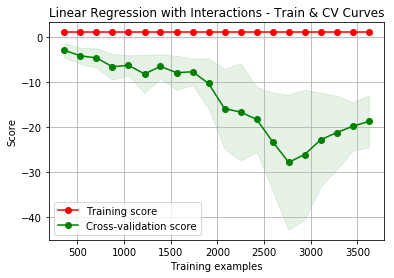

In [17]:
plot_learning_curve(lin_reg_intonly, "Linear Regression with Interactions - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

Adding interactions simply overfits. Let's also try adding quadratic terms to the normalized dataset to see if nonlinaer regression might help, although it will probably also overfit

In [18]:
poly = PolynomialFeatures(2)
X_normed_quad = poly.fit_transform(X_normed)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_normed_quad,y_normed, test_size=0.3, random_state=42)

In [20]:
quad_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
quad_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
scores_quad = cross_validate(quad_reg, X_train, y_train, cv=5, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [22]:
print 'Evaluation Metrics for Linear Regression with CV - Interactions Only Added: '
eval_metrics(scores_quad)

Evaluation Metrics for Linear Regression with CV - Interactions Only Added: 
Training R2 Mean:  1.0
Validation R2 Mean:  -18.218785475414716
Validation R2 STdev:  7.579716171161675
--
Training RMSE Mean:  1.2058314883839723e-12
Validation RMSE Mean:  0.2761818972815187
Validation RMSE STdev:  0.03406357589856793
--
Training MAE Mean:  8.946768039583637e-13
Validation MAE Mean:  0.10098000272546728
Validation MAE STdev:  0.011076181236455157


In [24]:
#Takes too long
#plot_learning_curve(quad_reg, "Linear Regression with Interactions - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
#                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

Despite all the attempts, the most promising model is Linear Regression. Let's try the same Linear Regression with the ratios features. We are probably going to overfit again but we will then do Feature Selection: the goal is to choose a good feature subset 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [26]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
scores_lin_ratios = cross_validate(lin_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [28]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin_ratios)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8733065839931479
Validation R2 Mean:  0.8133243179503324
Validation R2 STdev:  0.030313766068918037
--
Training RMSE Mean:  0.02217215383712329
Validation RMSE Mean:  0.026848322295433304
Validation RMSE STdev:  0.00013354893088785984
--
Training MAE Mean:  0.01709868134961517
Validation MAE Mean:  0.019740211987457505
Validation MAE STdev:  0.0010596981745041932


In [29]:
temp_pred = lin_reg.predict(X_test)
test_lin_ratios_nofs = np.sqrt(-mean_squared_error(y_test, temp_pred))

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


The model above is promising: the training RMSE has increased more than the validation RMSE, which is a sign that we may be approaching the sweet spot and getting close to starting to overfit

Feature Selection - We use this promising model above to pick only the best features

In [30]:
selector = RFECV(lin_reg, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_ratios, y_normed)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)

In [31]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 154


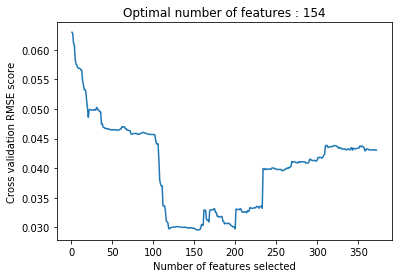

In [32]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

In [33]:
X_new = selector.transform(X_ratios)

All features have equally important ranking!

In [34]:
selector.ranking_

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,  54,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,  11,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,  59,  38,
        12,  15,  21,   4,   3,   1,   1,  47,   7,   1, 213,  96,  62,
        48,  27, 162,  95, 183, 180, 173, 198, 202, 185, 182, 219, 210,
       203, 177, 216, 121,  77, 147,  79,   1, 192, 111, 123,  29,  10,
       163, 161, 184, 181, 155, 218, 197, 189, 129, 205, 211, 20

Now let's rerun our best model so far and evaluate changes to model metrics resulting from removing unneeded features

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_normed, test_size=0.3, random_state=42)

In [36]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train,y_train)
scores_temp = cross_validate(lin_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_temp)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8444130577904871
Validation R2 Mean:  0.8154942393156489
Validation R2 STdev:  0.02093613822055549
--
Training RMSE Mean:  0.024570765346317712
Validation RMSE Mean:  0.02664613099249231
Validation RMSE STdev:  8.079808440104436e-05
--
Training MAE Mean:  0.018934807055332264
Validation MAE Mean:  0.0201393412748247
Validation MAE STdev:  0.000826057079101782


The validation RMSE has actually increased, while the accuracy has decreased slightly - this is bad but we make the choice to trade off a little bit of accuracy in order to shed complexity (we are losing more than 100 features this way)

Now we rebuild the model only with the important features i.e. number of features where val error is lowest - we do this in order to replicate what we created above with RFECV

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [38]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_normed.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking')
importances.head()

,RFECV_Ranking
description_TextPuncPerc,1
has_Dog(s),1
park_count_1km,1
has_Dryer,1
park_count_5km,1


We are restricting our features to the ones that minimize CV RMSE by feeding the new data into RFECV

In [39]:
best_features = list(importances.head(selector.n_features_).index)

In [40]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train[best_features],y_train)
scores_lin_ratios_fsel = cross_validate(lin_reg, X_train[best_features], y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin_ratios_fsel)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8367261556254737
Validation R2 Mean:  0.8141108210063507
Validation R2 STdev:  0.022811276118492093
--
Training RMSE Mean:  0.02517032237136816
Validation RMSE Mean:  0.02671513027489625
Validation RMSE STdev:  6.635340961824151e-05
--
Training MAE Mean:  0.019509586119261055
Validation MAE Mean:  0.020543593681065217
Validation MAE STdev:  0.0009910646197032963


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

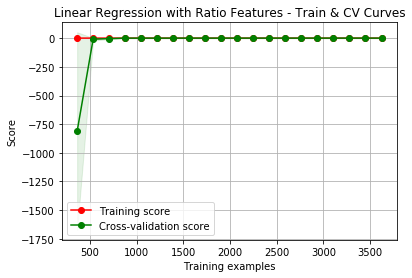

In [41]:
plot_learning_curve(lin_reg, "Linear Regression with Ratio Features - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

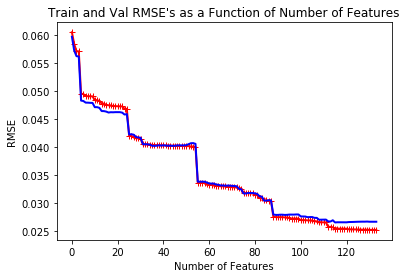

In [42]:
plot_rmse_features(lin_reg, X_train, y_train, best_features)

Finally, let's see how the models performs against our Test Set

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_normed, y_normed, test_size=0.3, random_state=42)

In [44]:
X_train_intonly, X_test_intonly, y_train_intonly, y_test_intonly = train_test_split(X_normed_wint,y_normed, test_size=0.3, random_state=42)

In [45]:
X_train_quad, X_test_quad, y_train_quad, y_test_quad = train_test_split(X_normed_quad,y_normed, test_size=0.3, random_state=42)

In [46]:
test_predictions_lin_reg_intonly = lin_reg_intonly.predict(X_test_intonly)
test_predictions_quad_reg = quad_reg.predict(X_test_quad)

Evaluation Metrics for Linear Regression with Interactions
Test R2:  -16.709542396569443
Test RMSE:  0.26462602311920624
Test MAE:  0.11509431643476861


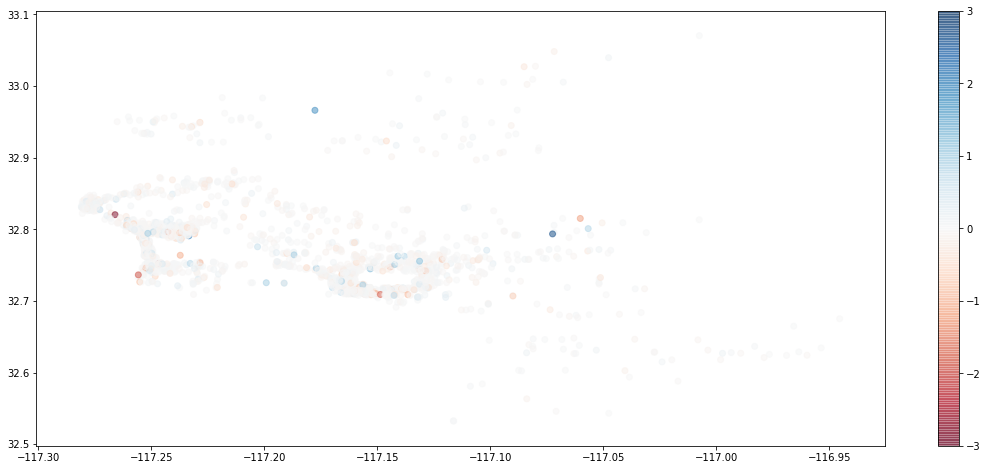

In [47]:
print 'Evaluation Metrics for Linear Regression with Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_lin_reg_intonly)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test_intonly, test_predictions_lin_reg_intonly))
print 'Test MAE: ',mean_absolute_error(y_test_intonly, test_predictions_lin_reg_intonly)
map_variable(y_test_intonly-test_predictions_lin_reg_intonly, listings)

Evaluation Metrics for Quadratic Regression without Interactions
Test R2:  -13.362161305774098
Test RMSE:  0.23830808703573528
Test MAE:  0.09784793064639409


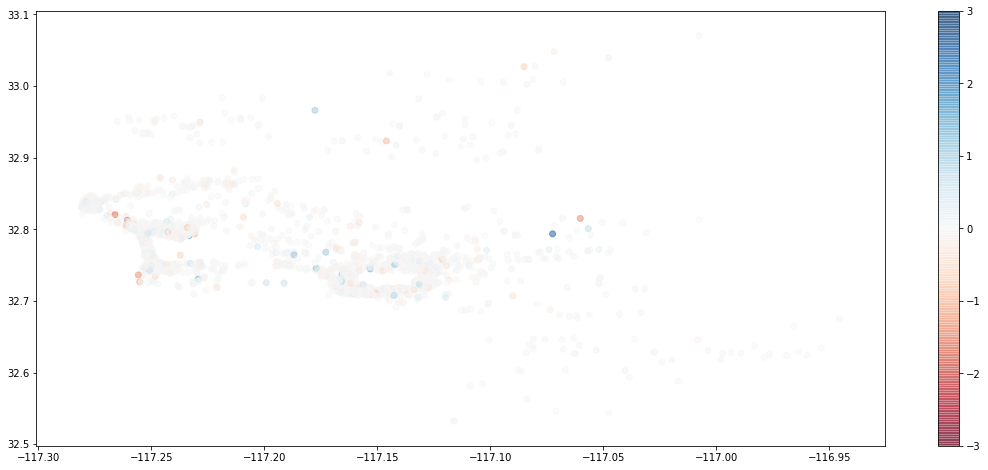

In [48]:
print 'Evaluation Metrics for Quadratic Regression without Interactions'
print 'Test R2: ',r2_score(y_test_quad, test_predictions_quad_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test_quad, test_predictions_quad_reg))
print 'Test MAE: ',mean_absolute_error(y_test_quad, test_predictions_quad_reg)
map_variable(y_test_quad-test_predictions_quad_reg, listings)

In [49]:
from yellowbrick.regressor import ResidualsPlot

In [50]:
# Takes too long
#lin_reg_intonly_pred_cv = cross_val_predict(lin_reg_intonly, X_train_intonly, y_train_intonly, cv=10)

In [51]:
#Takes too long
#quad_reg_pred_cv = cross_val_predict(quad_reg, X_train_quad, y_train_quad, cv=10)

Best model After Adding Ratios and Doing Feature Selection

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios[best_features], y_normed, test_size=0.3, random_state=42)

In [53]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train)
test_predictions_ratios_lin_reg_fs = lin_reg.predict(X_test)

Evaluation Metrics for Linear Regression with Ratio Features & Feature Selection
Test R2:  0.8292406714880289
Test RMSE:  0.025984902976912267
Test MAE:  0.019995258827420523


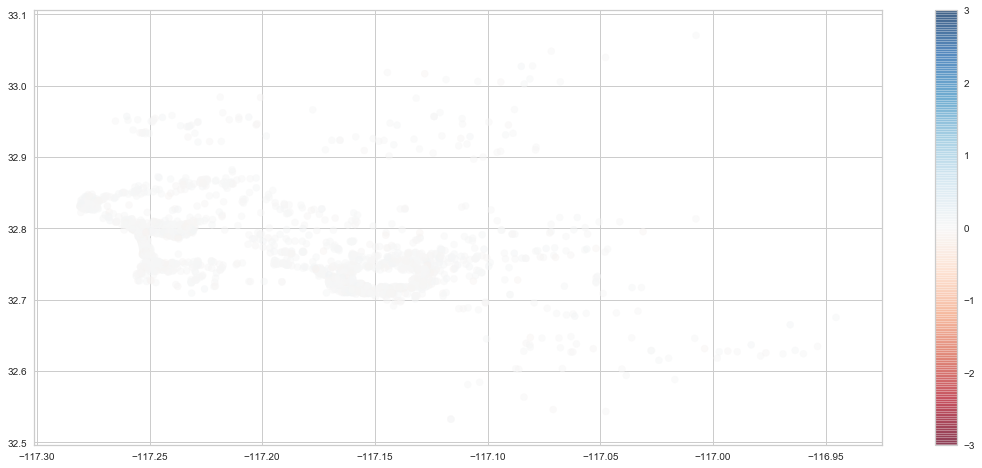

In [54]:
print 'Evaluation Metrics for Linear Regression with Ratio Features & Feature Selection'
print 'Test R2: ',r2_score(y_test, test_predictions_ratios_lin_reg_fs)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_ratios_lin_reg_fs))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_ratios_lin_reg_fs)
map_variable(y_test-test_predictions_ratios_lin_reg_fs, listings)

In [55]:
ratios_lin_reg_pred_cv = cross_val_predict(lin_reg, X_train, y_train, cv=10)

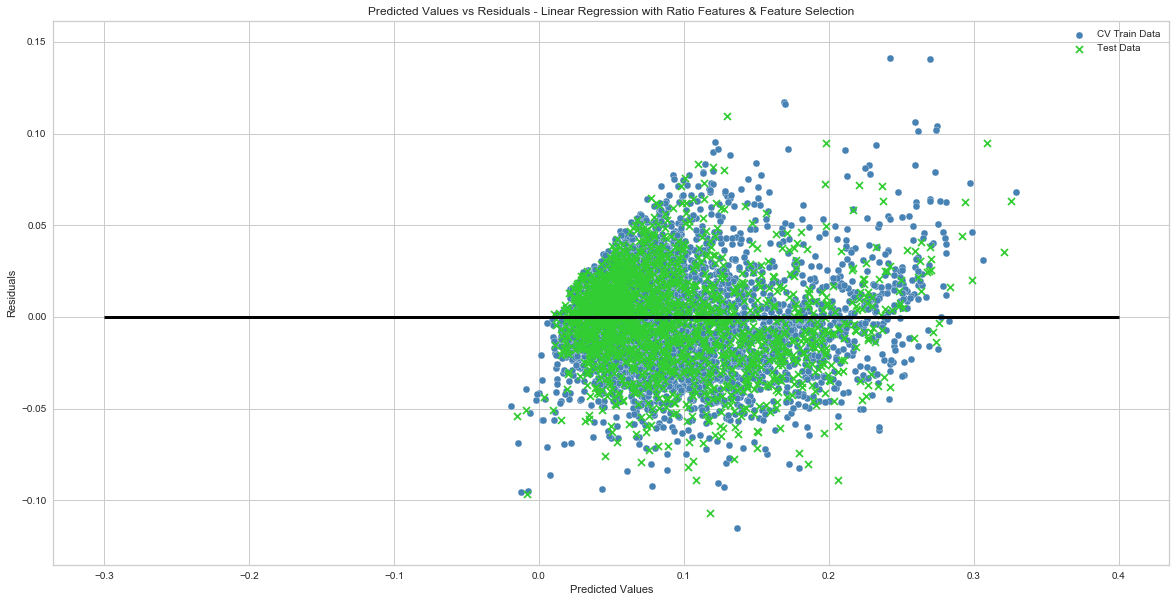

In [56]:
plt.figure(figsize=(20,10))
plt.scatter(ratios_lin_reg_pred_cv, ratios_lin_reg_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_ratios_lin_reg_fs, test_predictions_ratios_lin_reg_fs-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=-.3, xmax=.4, lw=3)
plt.title('Predicted Values vs Residuals - Linear Regression with Ratio Features & Feature Selection')
plt.show()

In [57]:
print 'This newest best model has %d features'%(len(best_features))

This newest best model has 138 features


In [58]:
#%store scores_lin, scores_tree, scores_sv_reg, scores_neigh_reg

In [59]:
ranks["Linear_Reg_Int_Only"] = rank_to_dict(np.abs(lin_reg_intonly.coef_), X_normed.columns)
ranks["Quad_Reg"] = rank_to_dict(np.abs(quad_reg.coef_), X_normed.columns)
ranks["Linear_Reg_Ratios"] = rank_to_dict(np.abs(lin_reg.coef_), X_ratios.columns)

In [60]:
%store scores_lin_intonly
%store scores_lin_ratios
%store scores_lin_ratios_fsel
%store scores_quad

Stored 'scores_lin_intonly' (dict)
Stored 'scores_lin_ratios' (dict)
Stored 'scores_lin_ratios_fsel' (DeprecationDict)
Stored 'scores_quad' (dict)


In [61]:
%store test_lin_ratios_nofs

Stored 'test_lin_ratios_nofs' (float64)


In [62]:
%store test_predictions_ratios_lin_reg_fs
%store test_predictions_lin_reg_intonly
%store test_predictions_quad_reg

Stored 'test_predictions_ratios_lin_reg_fs' (ndarray)
Stored 'test_predictions_lin_reg_intonly' (ndarray)
Stored 'test_predictions_quad_reg' (ndarray)


In [63]:
%store y_test_intonly
%store y_test_quad

Stored 'y_test_intonly' (Series)
Stored 'y_test_quad' (Series)


In [ ]:
%store ranks